In [1]:
from google.colab import drive
drive.mount('/content/drive/')

import numpy as np
import pandas as pd
import copy

import datetime
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt

!pip install dfply
from dfply import *

Mounted at /content/drive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 6.9 MB/s eta 0:00:00


In [2]:
# Import raw data

path = 'drive/My Drive/Guzman Energy Interview/Assignment 2/'
data_raw_hour = pd.read_csv(path + 'Assignment 2 - USA_AL_Auburn-Opelika.AP.722284_TMY3_BASE.csv').set_index(['Date/Time'])
data_raw_minute = pd.read_csv(path + 'Assignment 2 - new.app4.csv').set_index(['Unnamed: 0'])

In [3]:
data_raw_hour

,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly)
Date/Time,,,,,,,,,,,,,
01/01 01:00:00,0.974334,4.452977,0.0,4.425010,0.0,0.112709,0.112709,0.112709,0.154019,0.033180,0.092943,0.406035,0.158803
01/01 02:00:00,0.796582,4.850317,0.0,4.824566,0.0,0.122617,0.122617,0.122617,0.089845,0.019355,0.076186,0.373851,0.098084
01/01 03:00:00,0.735028,5.037645,0.0,5.012193,0.0,0.127099,0.127099,0.127099,0.064175,0.013825,0.062326,0.369517,0.081442
01/01 04:00:00,0.727433,5.107562,0.0,5.082468,0.0,0.128391,0.128391,0.128391,0.064175,0.013825,0.053976,0.364315,0.086107
01/01 05:00:00,0.778706,5.270878,0.0,5.246732,0.0,0.132549,0.132549,0.132549,0.064175,0.013825,0.065823,0.350553,0.135137
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31 20:00:00,2.601121,0.044507,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.743542,0.160179,0.349591,0.646167,0.684999
12/31 21:00:00,2.445630,0.046038,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.677155,0.145877,0.310730,0.668381,0.626843
12/31 22:00:00,2.206391,0.044963,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.570934,0.122994,0.293949,0.652777,0.549092


In [4]:
data_raw_minute

,time,W_min
Unnamed: 0,,
1,6/7/2013 11:04,1142.919571
2,6/7/2013 11:05,371.239567
3,6/7/2013 11:06,367.887333
4,6/7/2013 11:07,702.714100
5,6/7/2013 11:08,1655.944450
...,...,...
10842,9/17/2013 23:06,1.316350
10843,9/17/2013 23:07,1.309550
10844,9/17/2013 23:08,1.296950


In [5]:
# Adjust time format for other appliances

data_other = data_raw_hour.copy()
data_other['temp_standard_time'] = [x[:8] + '00' + x[10:] if x[8:10] == '24' else x for x in data_other.index]
data_other['temp_date_hour'] = [datetime.datetime.strptime('2013'+x, '%Y %m/%d %H:00:00') for x in data_other['temp_standard_time']]
data_other['date_hour'] = [x + relativedelta(days = 1) if x.hour == 0 else x for x in data_other['temp_date_hour']]
data_other = data_other >> drop(['temp_standard_time', 'temp_date_hour'])
data_other = data_other.set_index(['date_hour'])

In [6]:
# Adjust time format and electricity unit for new appliance

data_new = data_raw_minute.copy()
data_new['date_hour'] = [datetime.datetime.strptime(x[:-3], '%m/%d/%Y %H') for x in data_new['time']]
data_new['New Appliance:Electricity [kW](Hourly)'] = data_new['W_min'] / 1000
data_new = data_new >> drop(['time', 'W_min'])

# Group minute data into hourly data

data_new = data_new.groupby('date_hour').mean()

In [7]:
# Select, merge and sum all electricity data

data_electricity = data_other >> outer_join(data_new, by = 'date_hour') >> select(contains('Electricity'))
data_electricity['Electricity:All [kW](Hourly)'] = data_electricity.sum(1)

In [8]:
data_electricity

,Electricity:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly),New Appliance:Electricity [kW](Hourly),Electricity:All [kW](Hourly)
date_hour,,,,,,,,,,,,,
2013-01-01 01:00:00,0.974334,0.0,0.0,0.112709,0.112709,0.112709,0.154019,0.033180,0.092943,0.406035,0.158803,NaN,2.157443
2013-01-01 02:00:00,0.796582,0.0,0.0,0.122617,0.122617,0.122617,0.089845,0.019355,0.076186,0.373851,0.098084,NaN,1.821755
2013-01-01 03:00:00,0.735028,0.0,0.0,0.127099,0.127099,0.127099,0.064175,0.013825,0.062326,0.369517,0.081442,NaN,1.707610
2013-01-01 04:00:00,0.727433,0.0,0.0,0.128391,0.128391,0.128391,0.064175,0.013825,0.053976,0.364315,0.086107,NaN,1.695004
2013-01-01 05:00:00,0.778706,0.0,0.0,0.132549,0.132549,0.132549,0.064175,0.013825,0.065823,0.350553,0.135137,NaN,1.805868
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 20:00:00,2.601121,0.0,0.0,0.000000,0.000000,0.000000,0.743542,0.160179,0.349591,0.646167,0.684999,NaN,5.185598
2013-12-31 21:00:00,2.445630,0.0,0.0,0.000000,0.000000,0.000000,0.677155,0.145877,0.310730,0.668381,0.626843,NaN,4.874615
2013-12-31 22:00:00,2.206391,0.0,0.0,0.000000,0.000000,0.000000,0.570934,0.122994,0.293949,0.652777,0.549092,NaN,4.396137


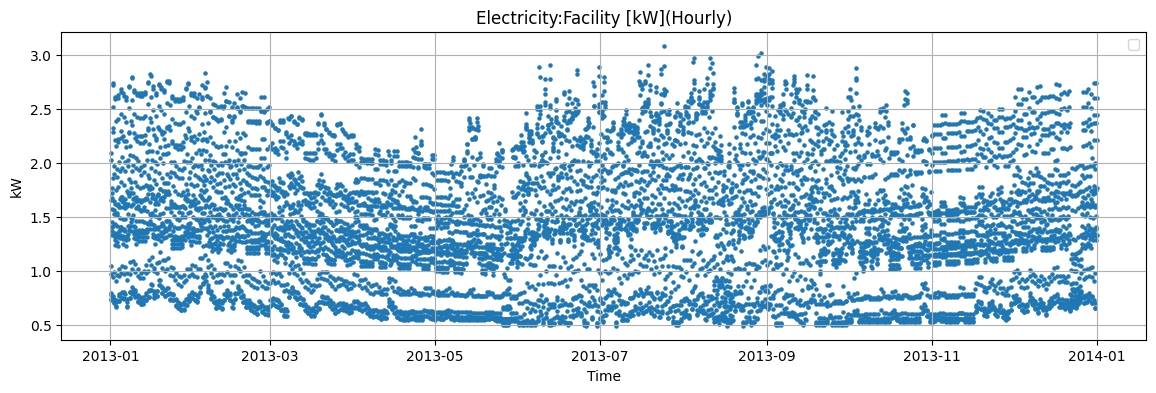

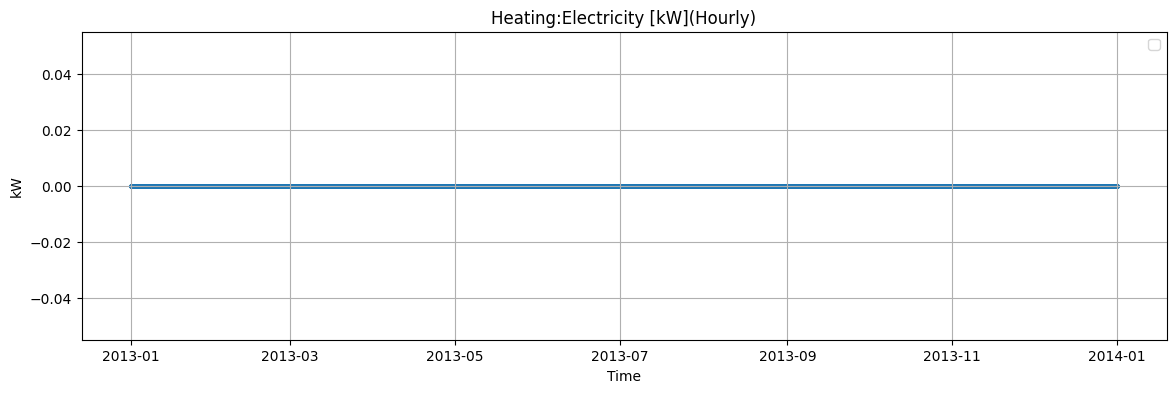

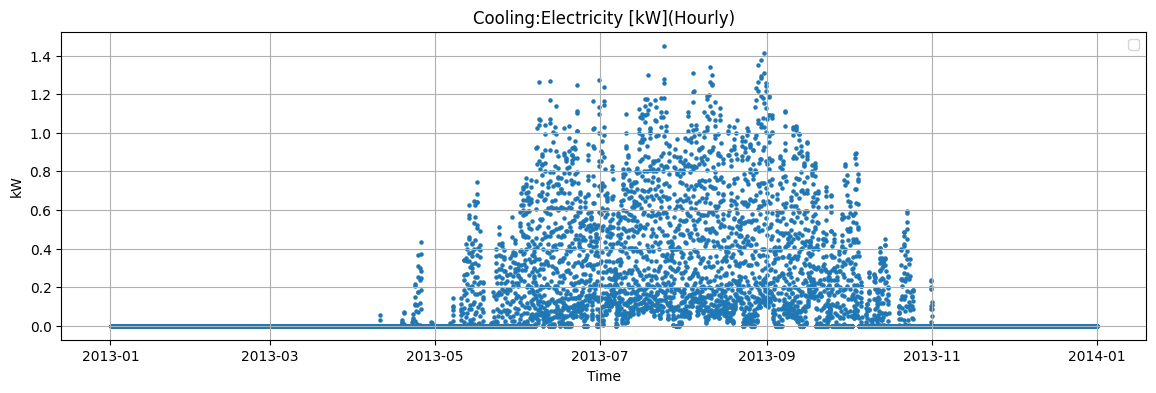

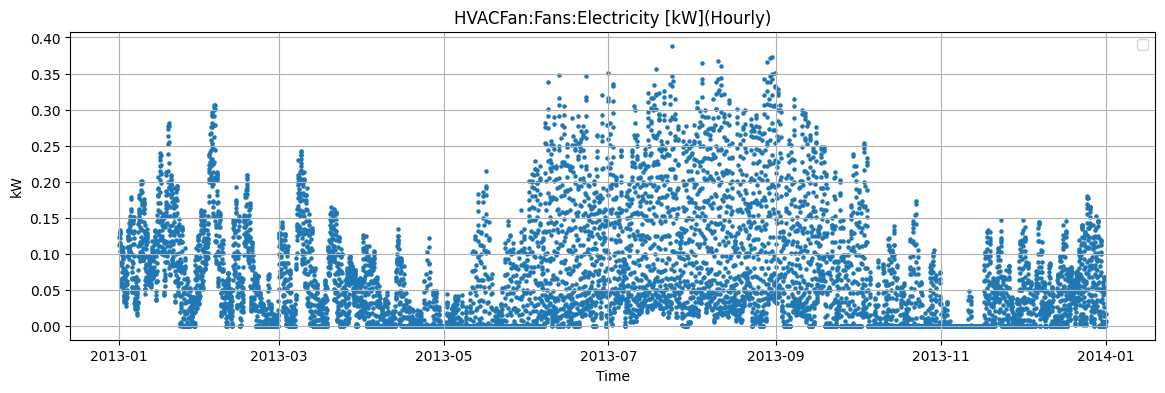

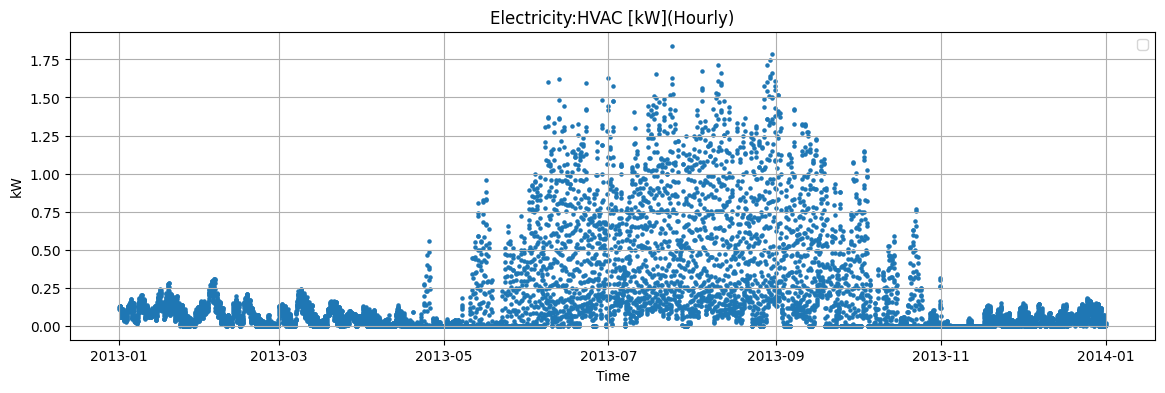

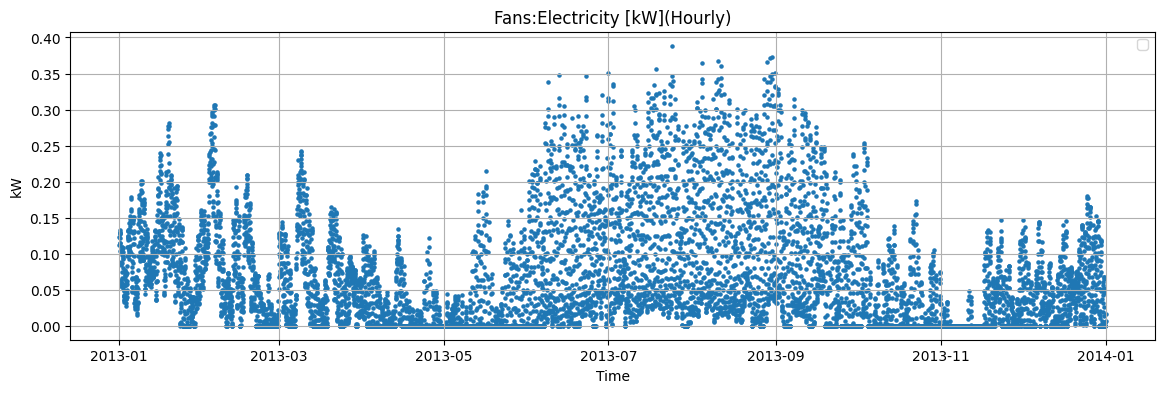

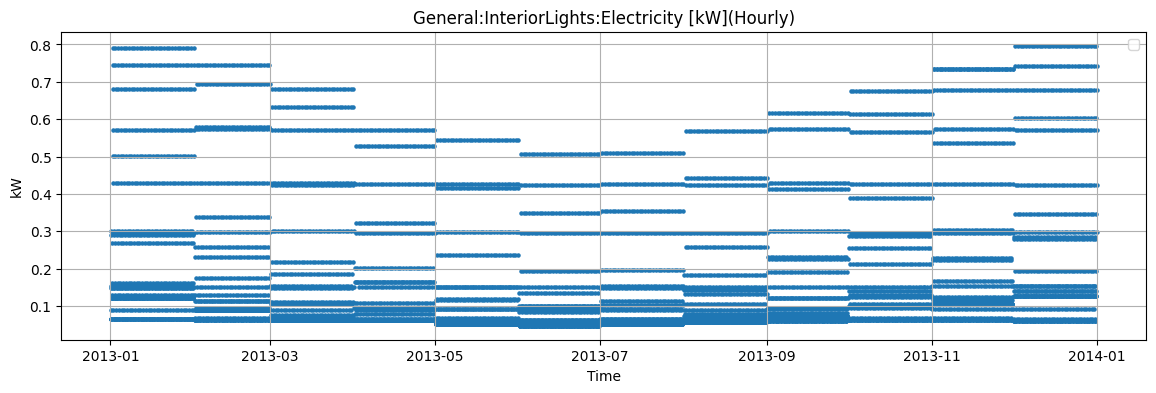

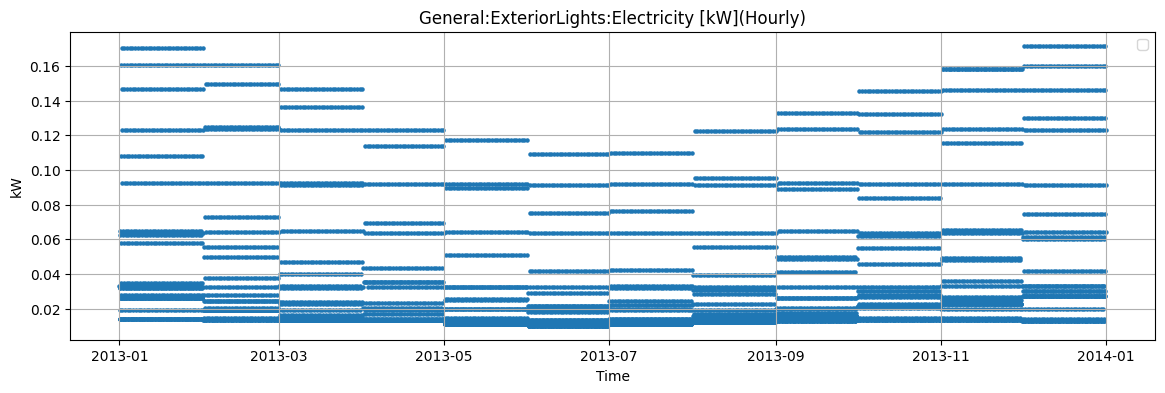

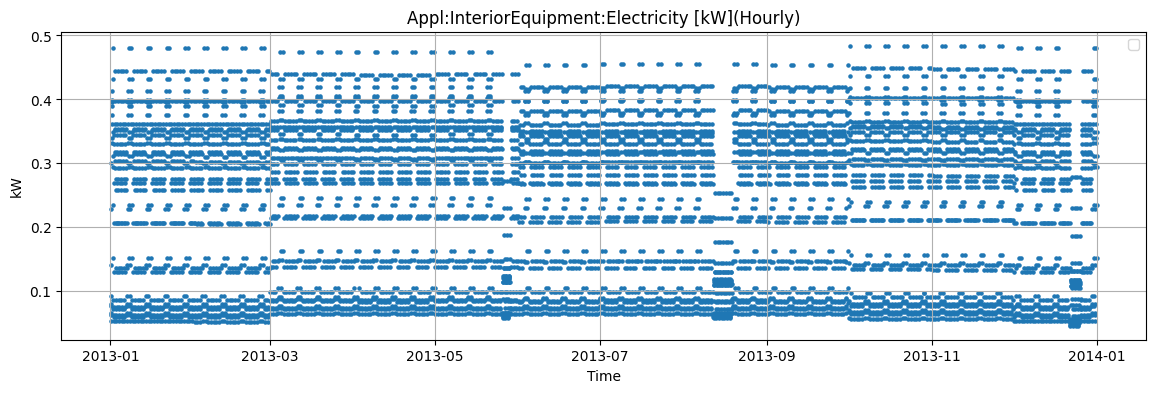

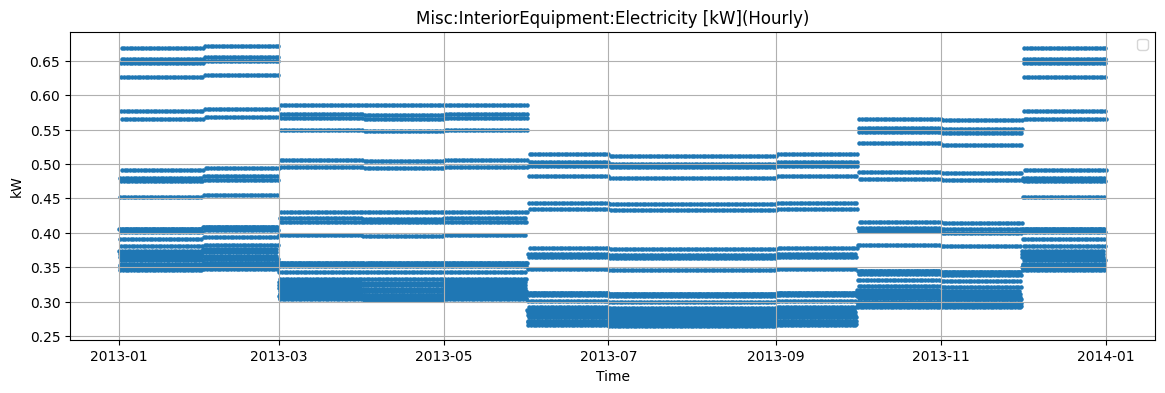

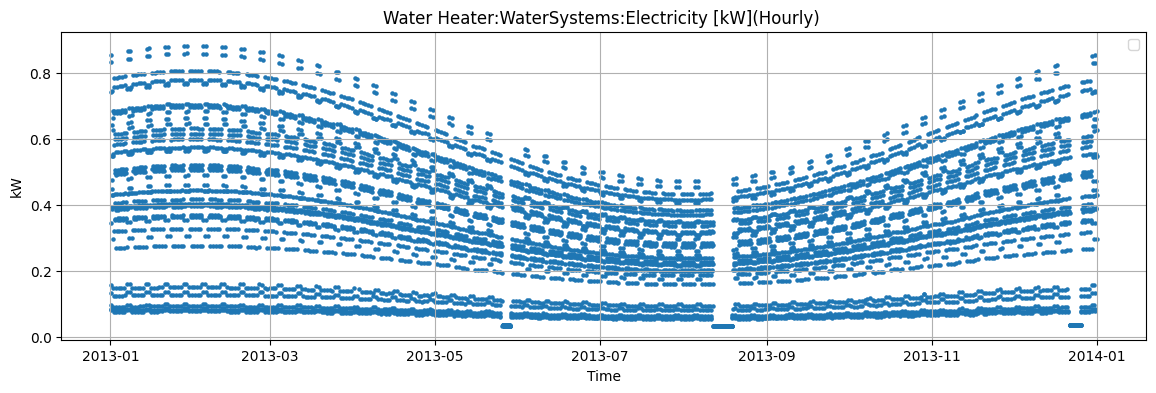

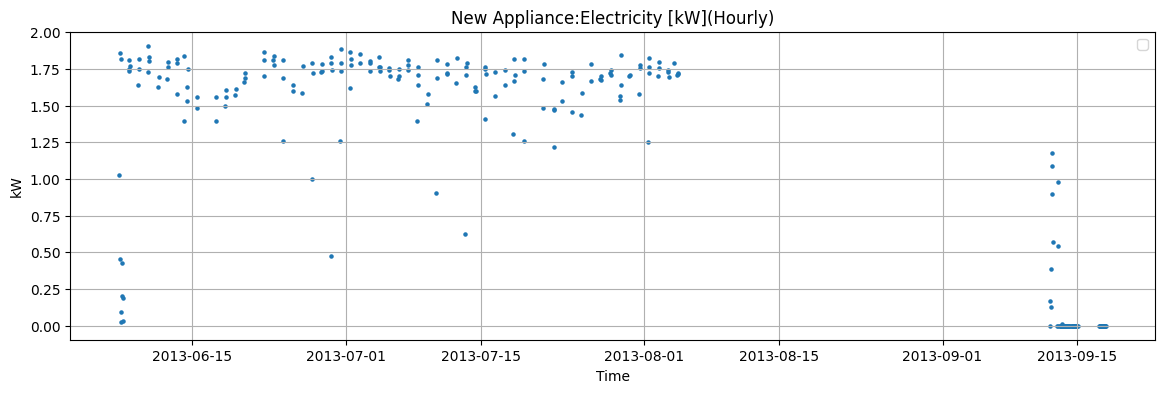

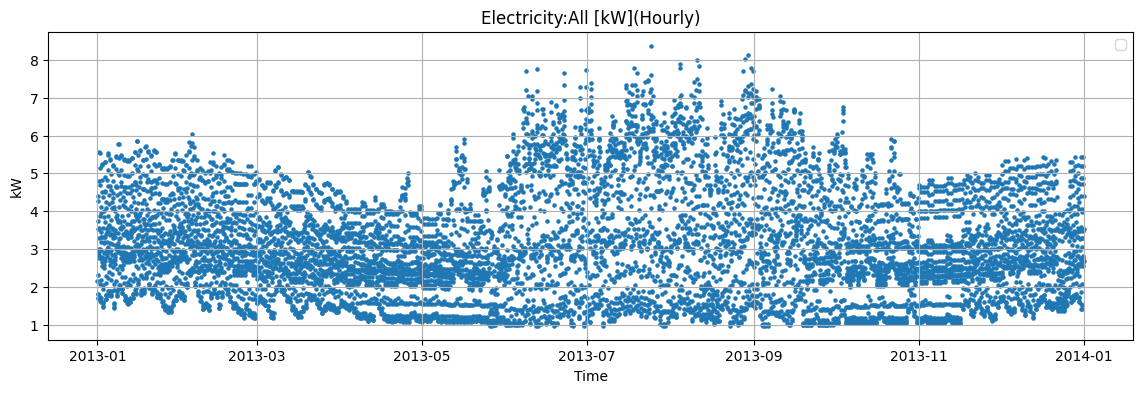

In [9]:
for i in range(len(data_electricity.columns)): 
  plt.figure(i, figsize = (14, 4))
  plt.scatter(data_electricity.index, data_electricity[data_electricity.columns[i]], s = 5)
  plt.xlabel('Time')
  plt.ylabel('kW')
  plt.title(data_electricity.columns[i])
  plt.legend()
  plt.grid()

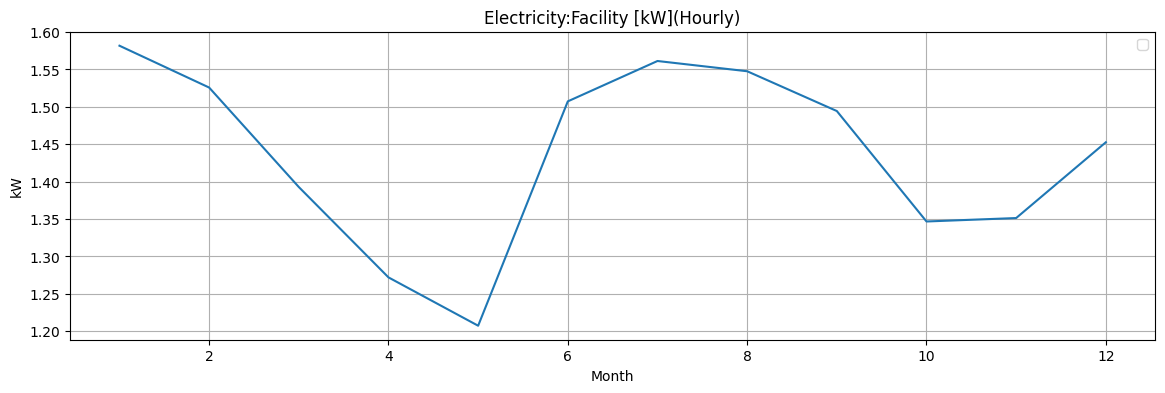

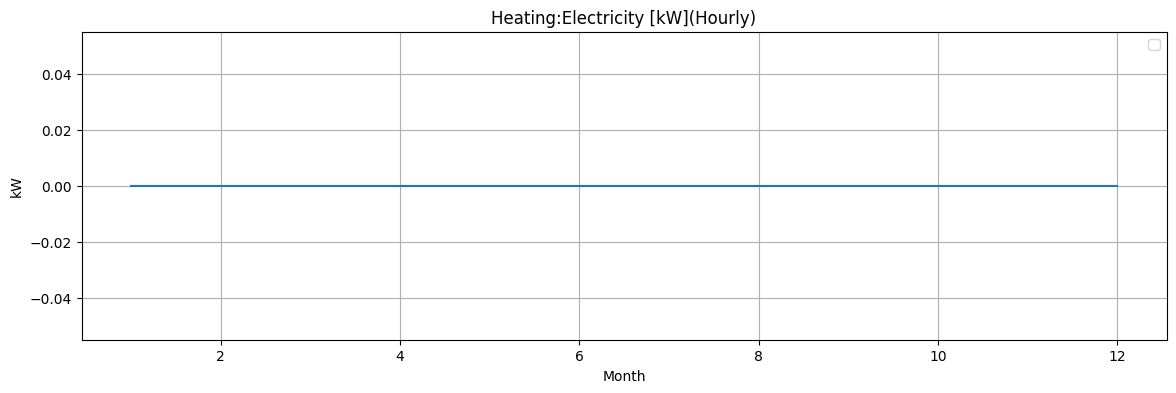

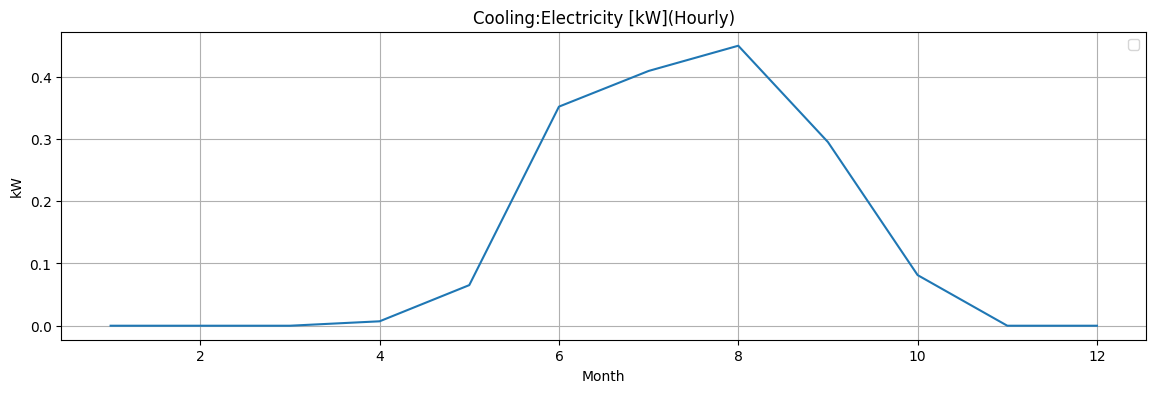

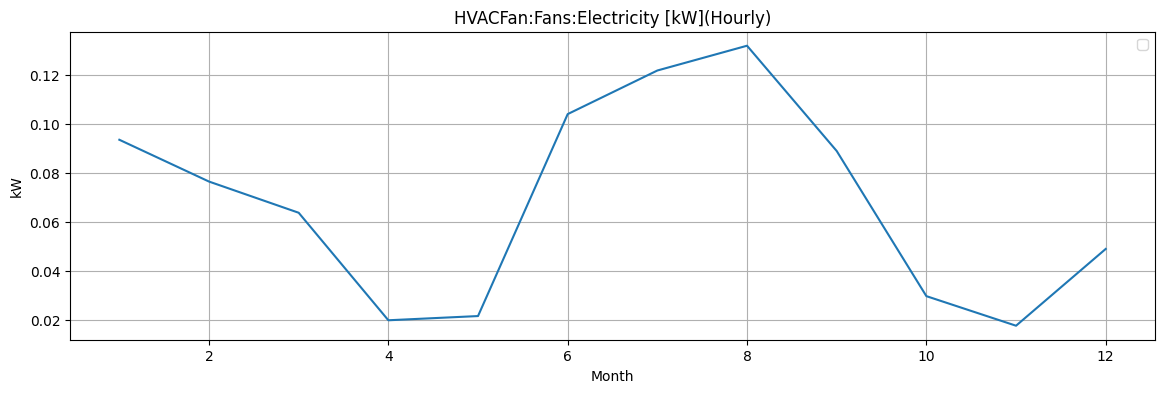

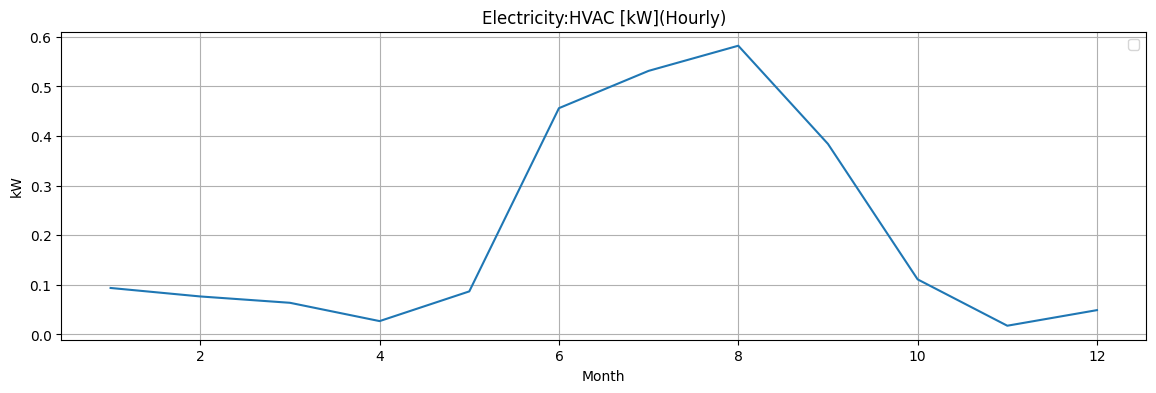

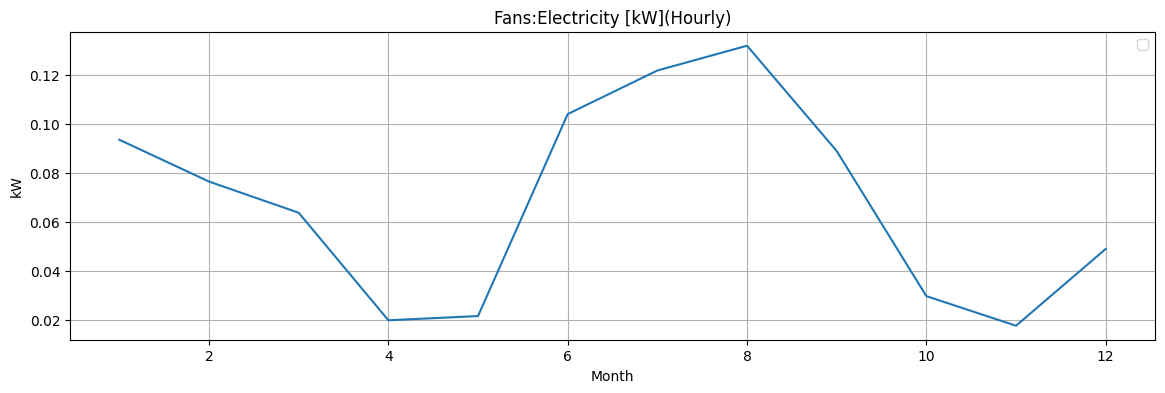

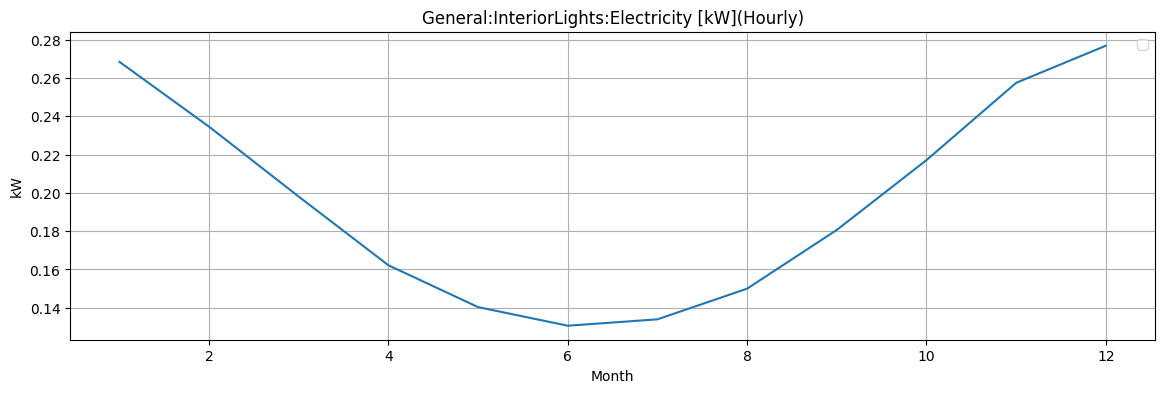

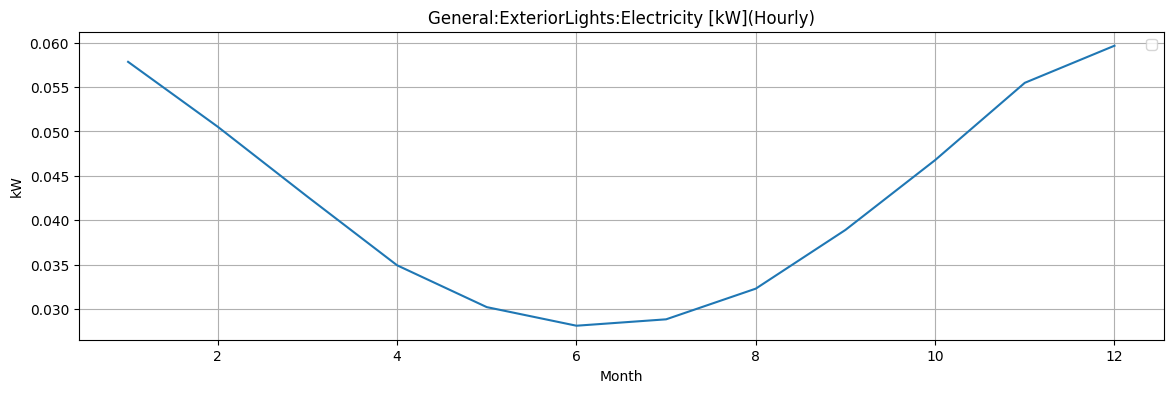

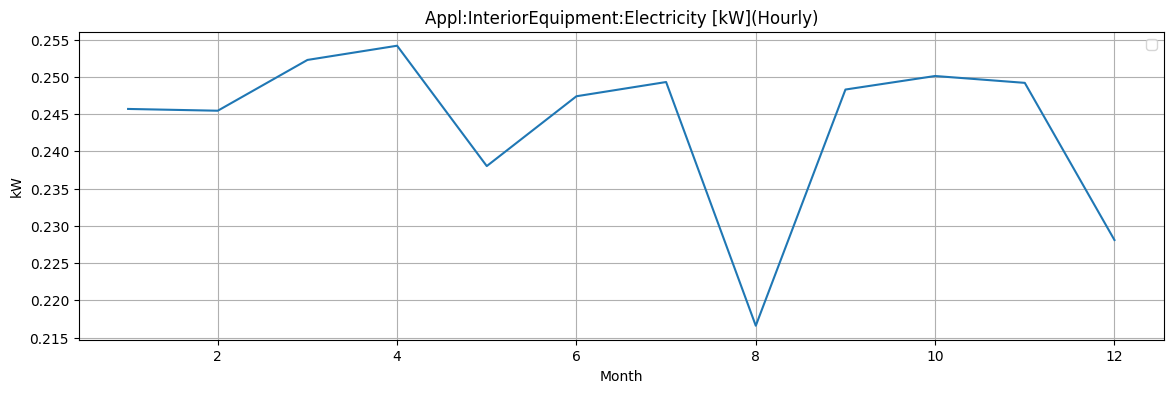

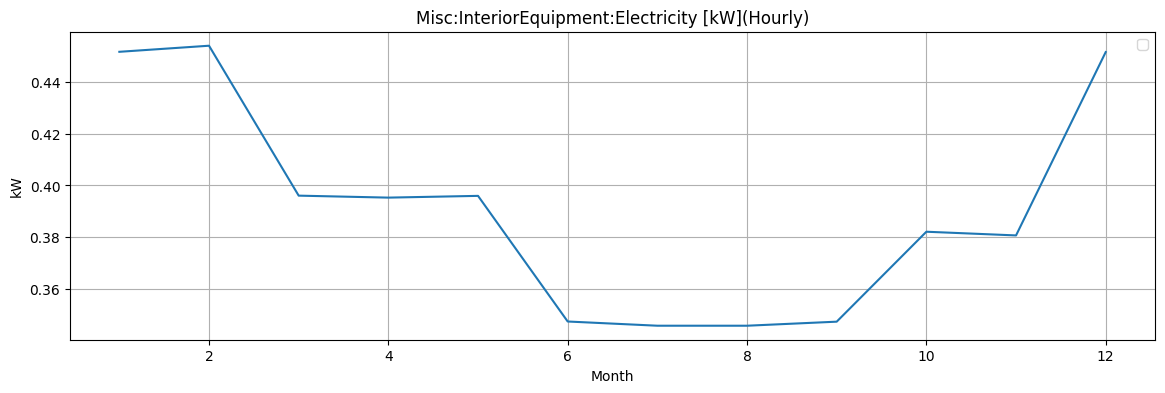

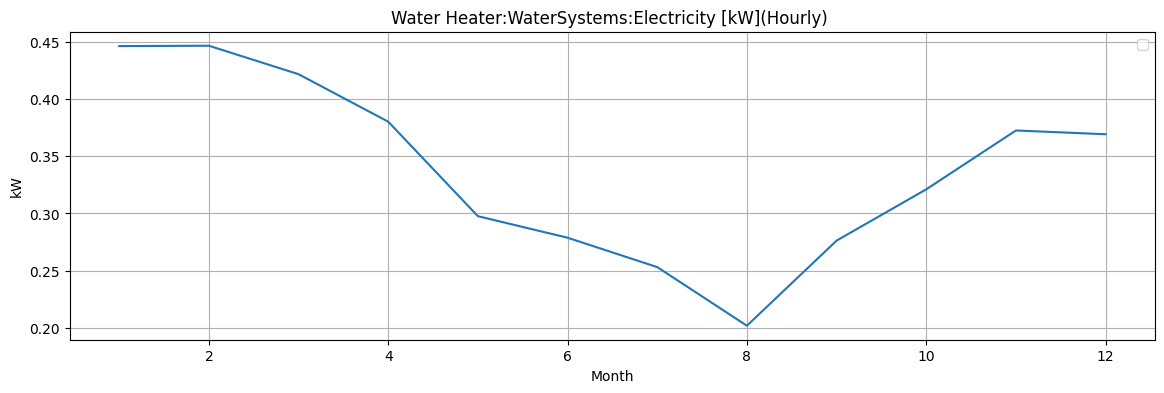

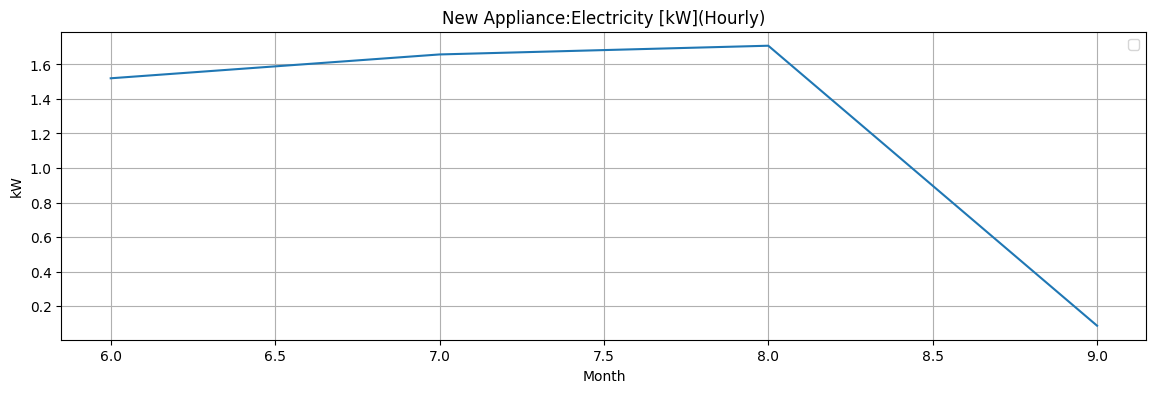

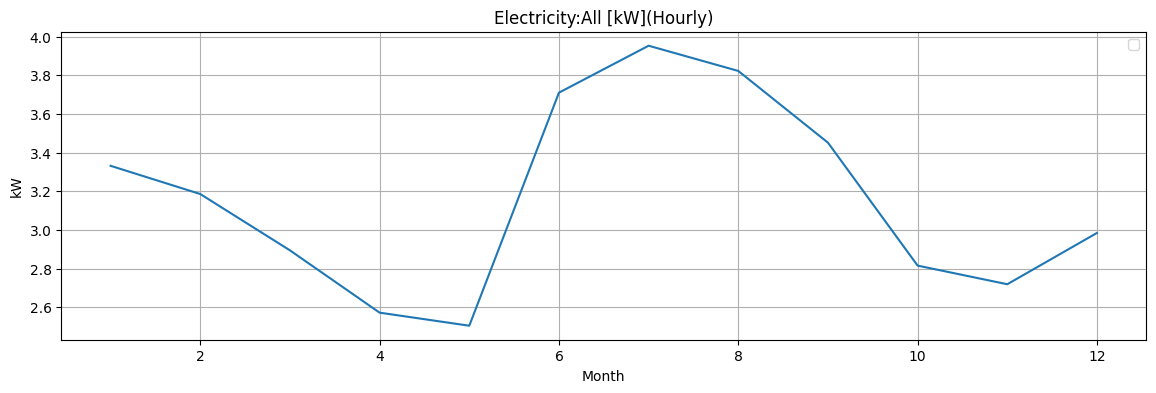

In [10]:
# Group data by month

data_month = data_electricity.copy()
data_month['month'] = [x.month for x in data_month.index]
data_month = data_month.groupby('month').mean()

data = data_month
for i in range(len(data.columns)): 
  plt.figure(i, figsize = (14, 4))
  plt.plot(data.index, data[data.columns[i]])
  plt.xlabel('Month')
  plt.ylabel('kW')
  plt.title(data.columns[i])
  plt.legend()
  plt.grid()

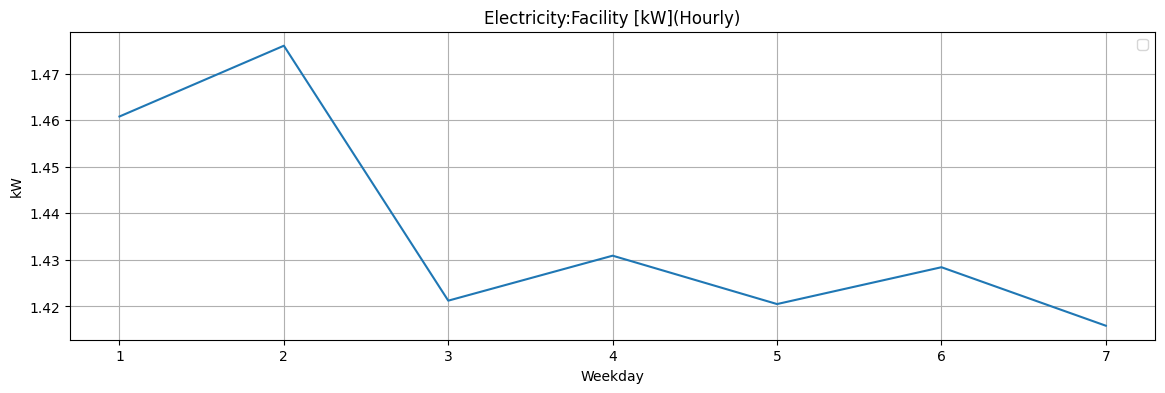

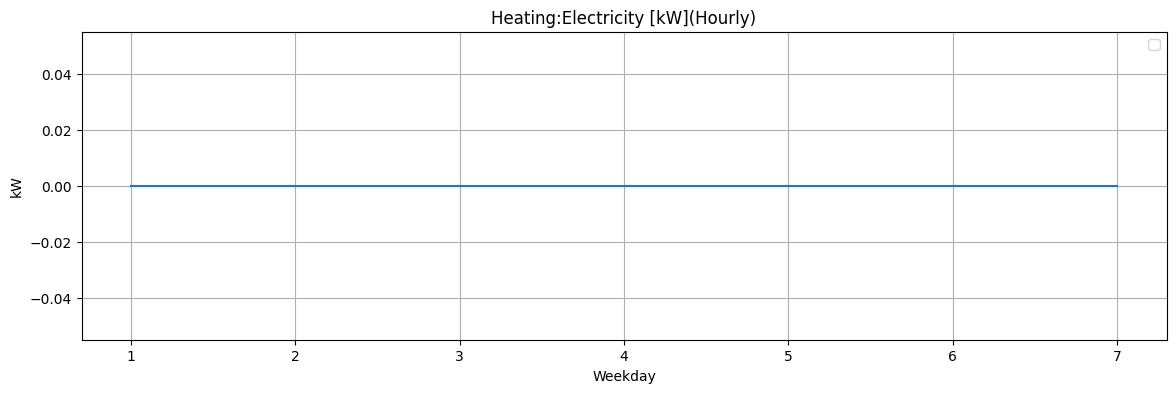

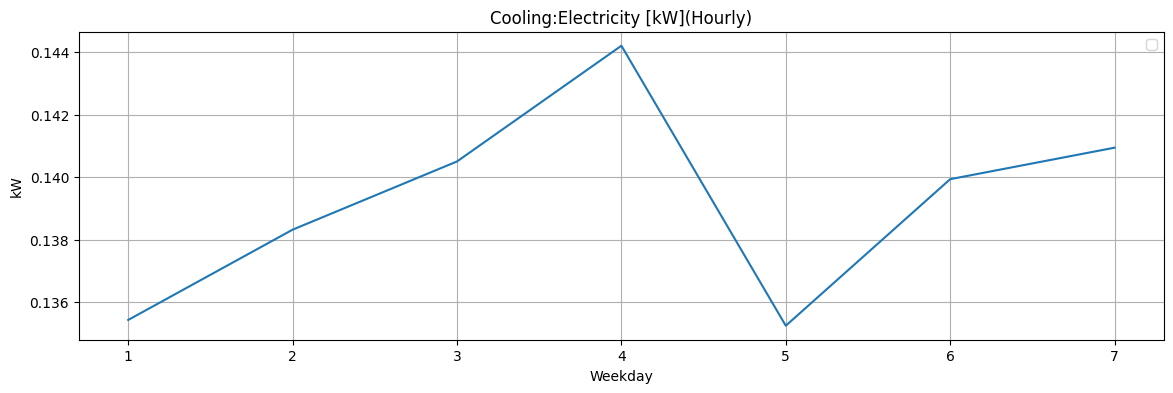

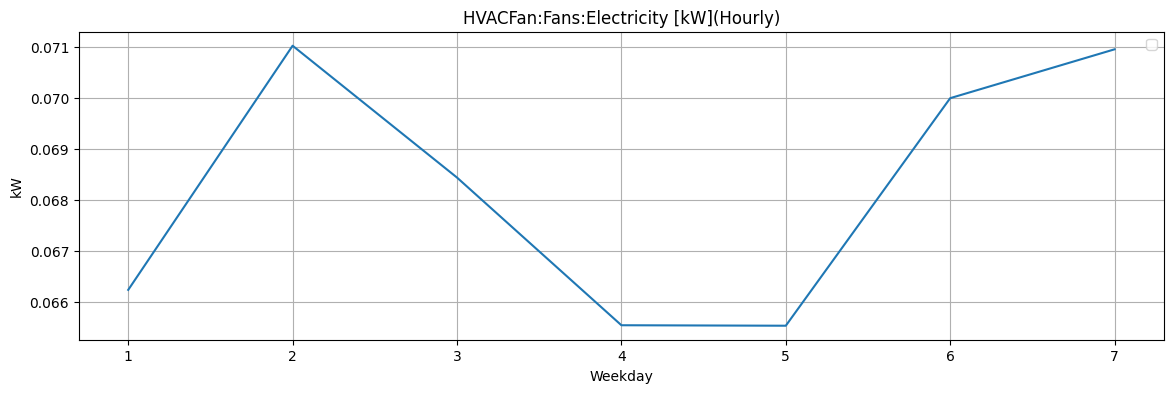

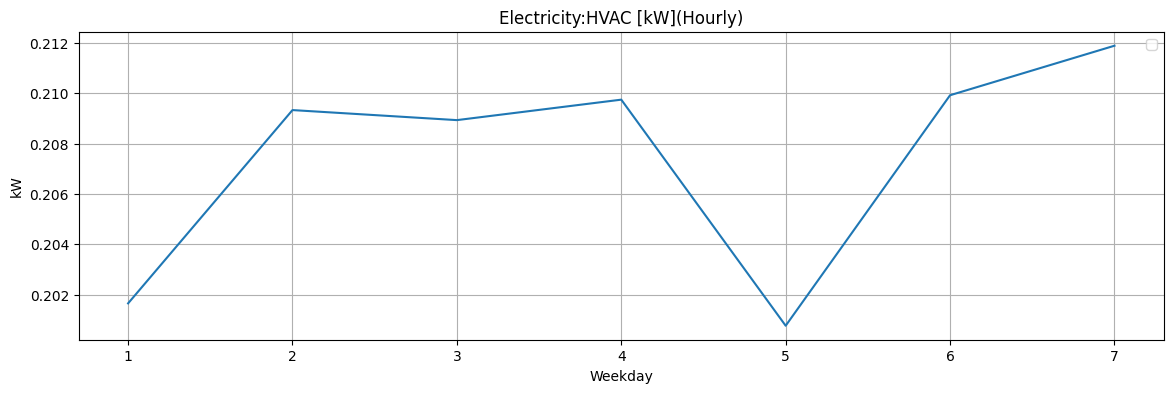

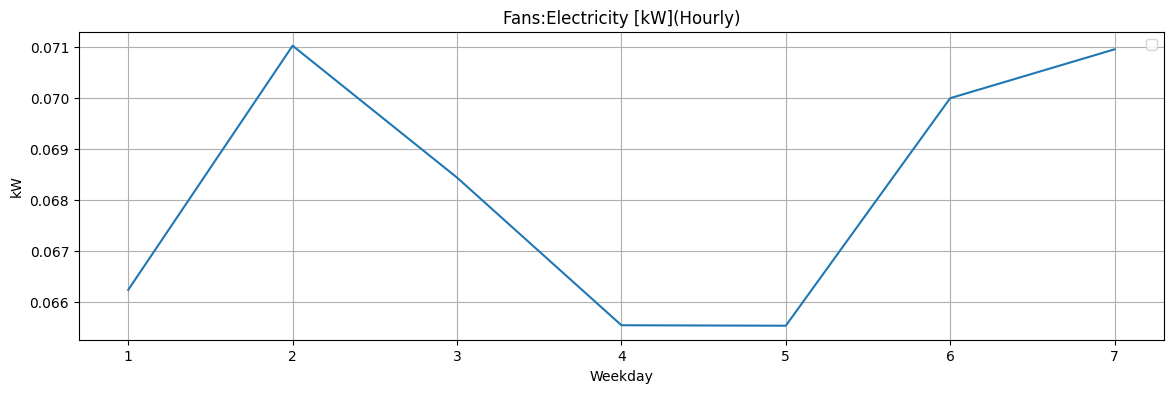

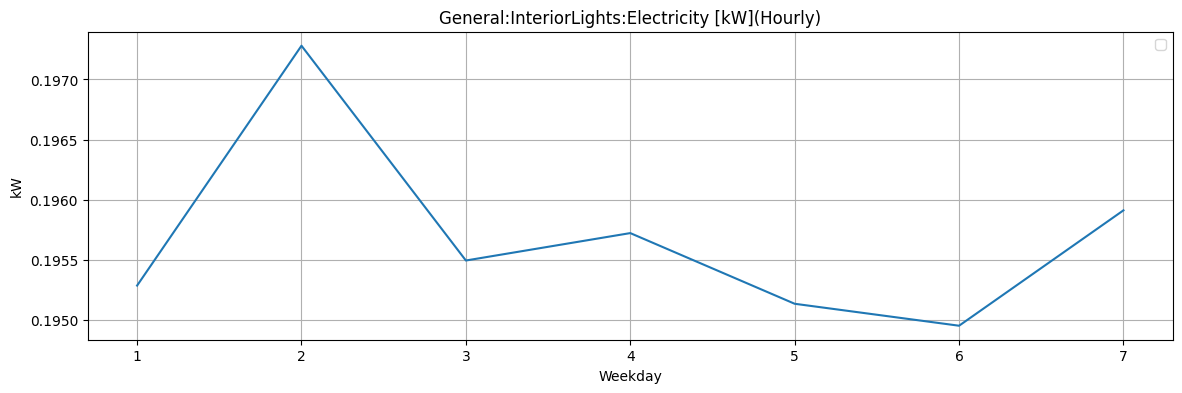

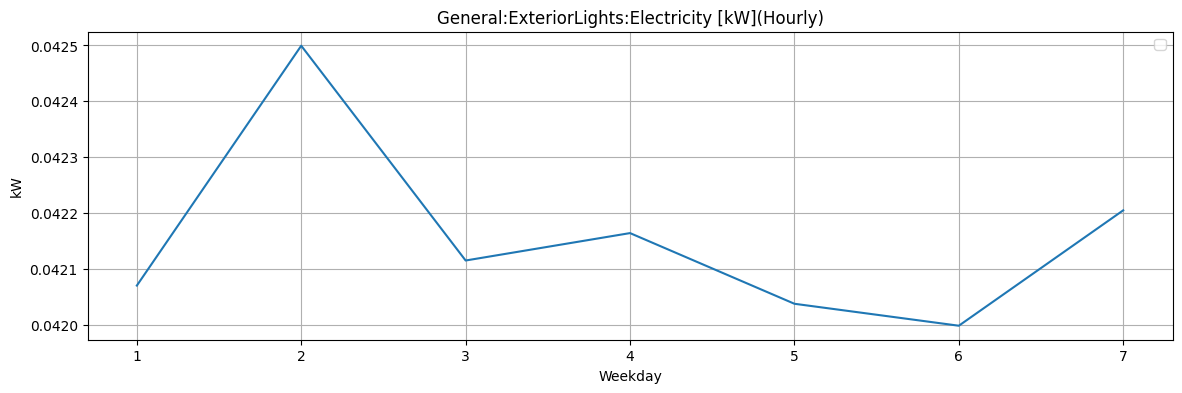

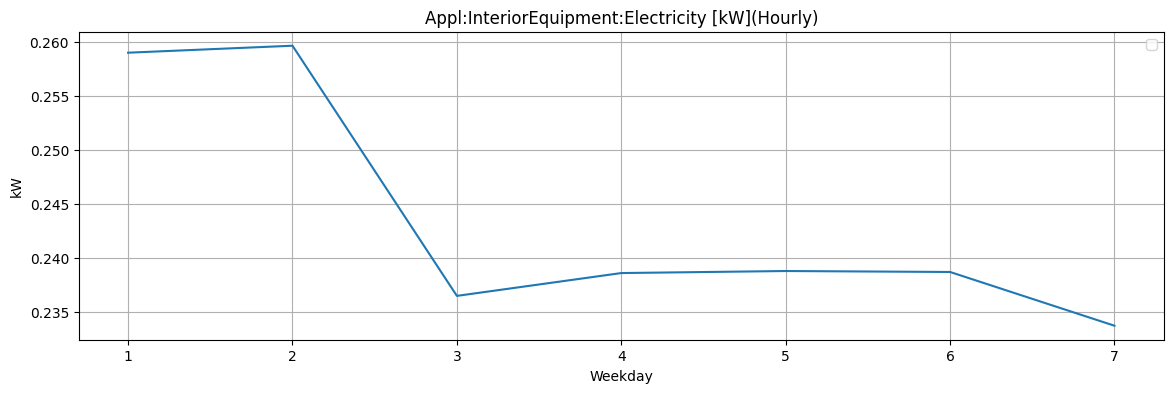

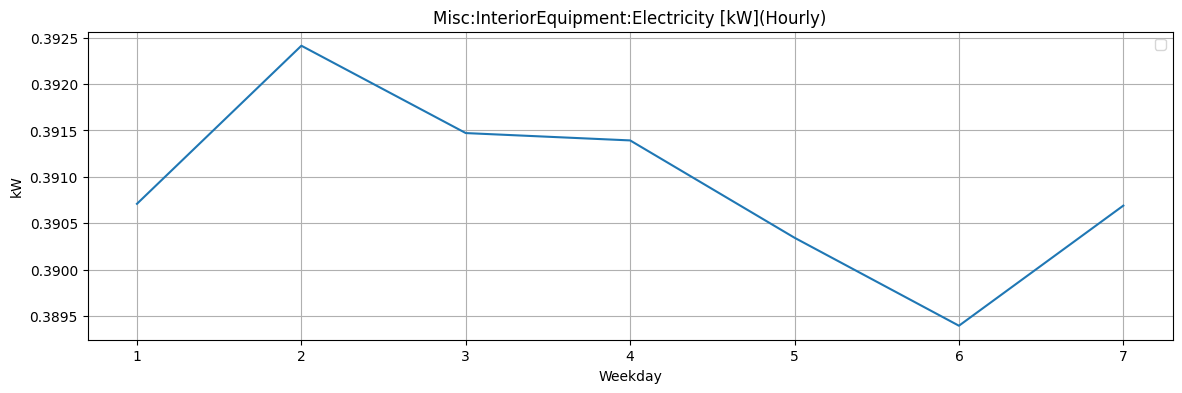

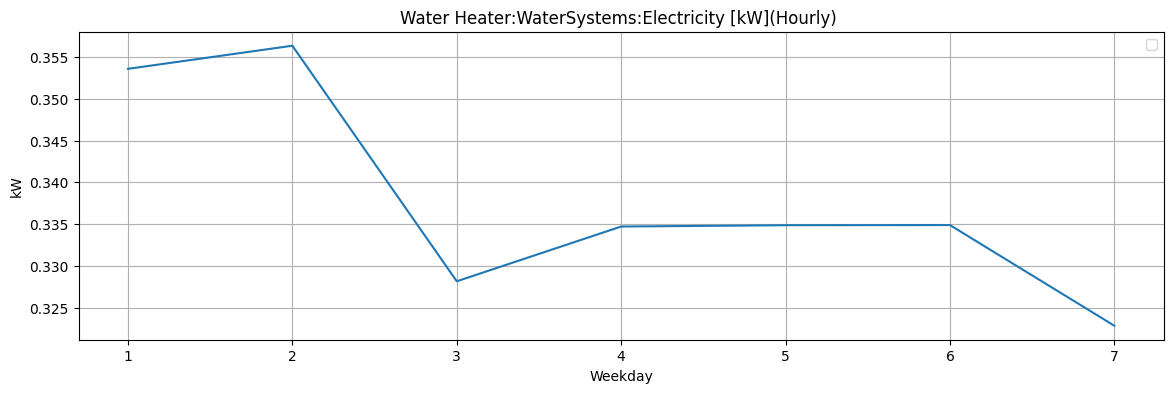

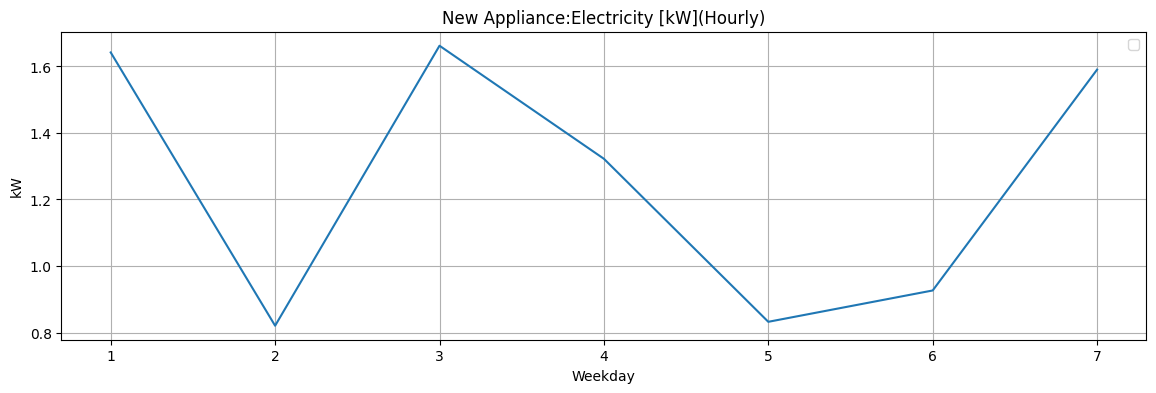

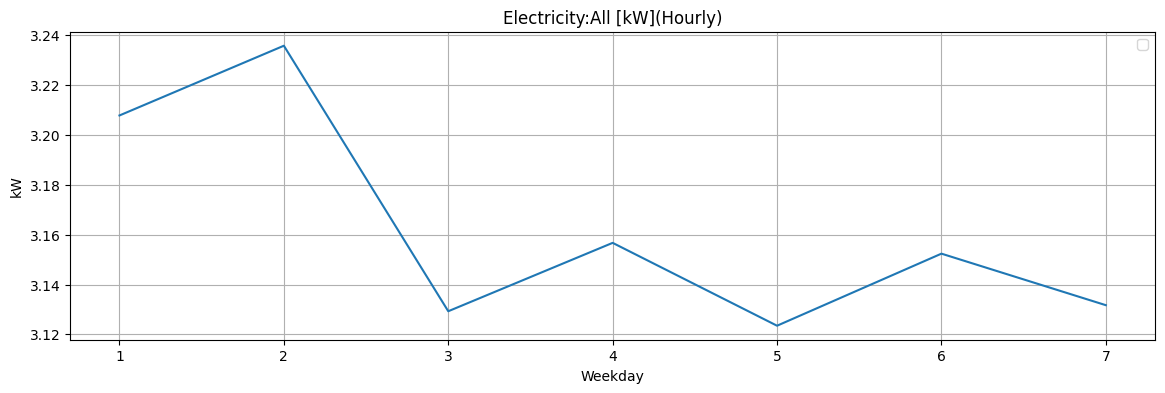

In [11]:
# Group data by weekday

data_weekday = data_electricity.copy()
data_weekday['weekday'] = [x.isoweekday() for x in data_weekday.index]
data_weekday = data_weekday.groupby('weekday').mean()

data = data_weekday
for i in range(len(data.columns)): 
  plt.figure(i, figsize = (14, 4))
  plt.plot(data.index, data[data.columns[i]])
  plt.xlabel('Weekday')
  plt.ylabel('kW')
  plt.title(data.columns[i])
  plt.legend()
  plt.grid()

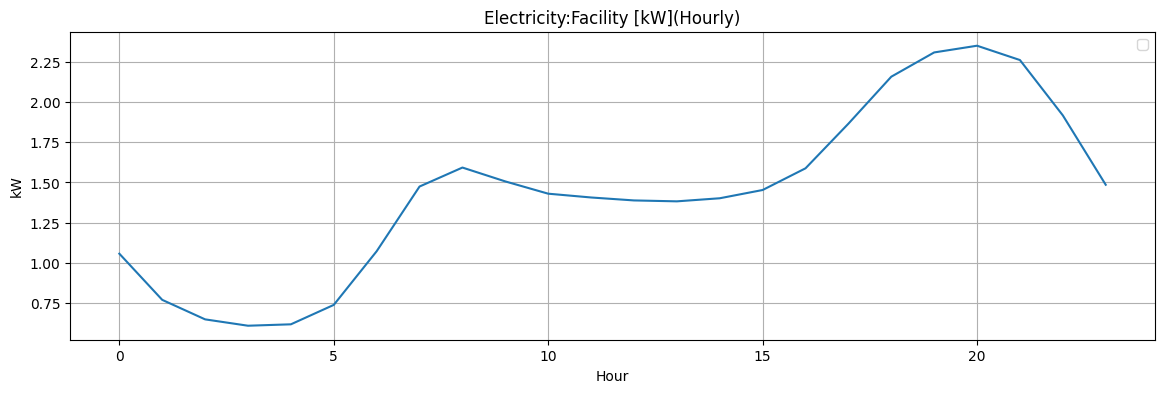

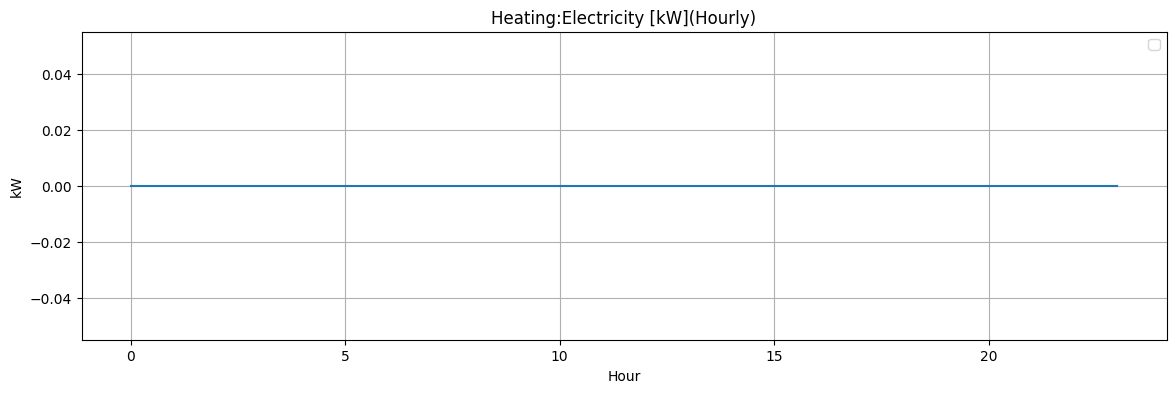

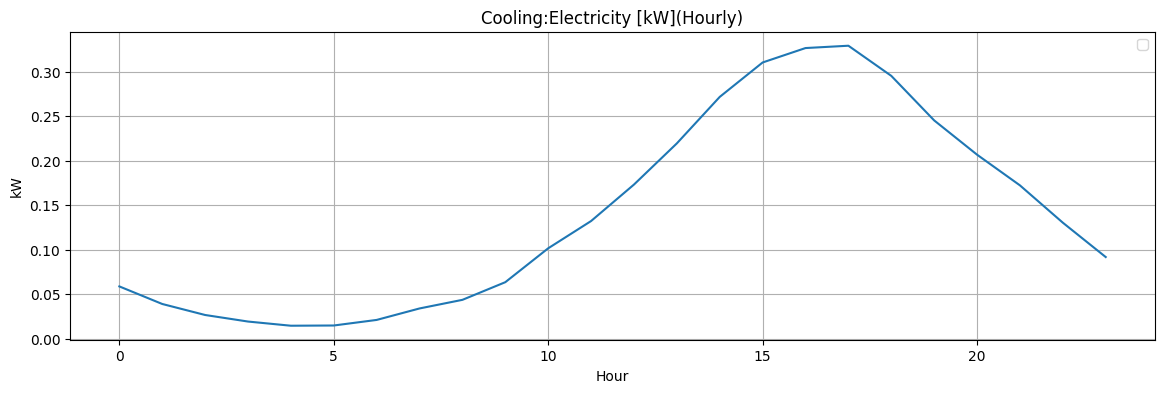

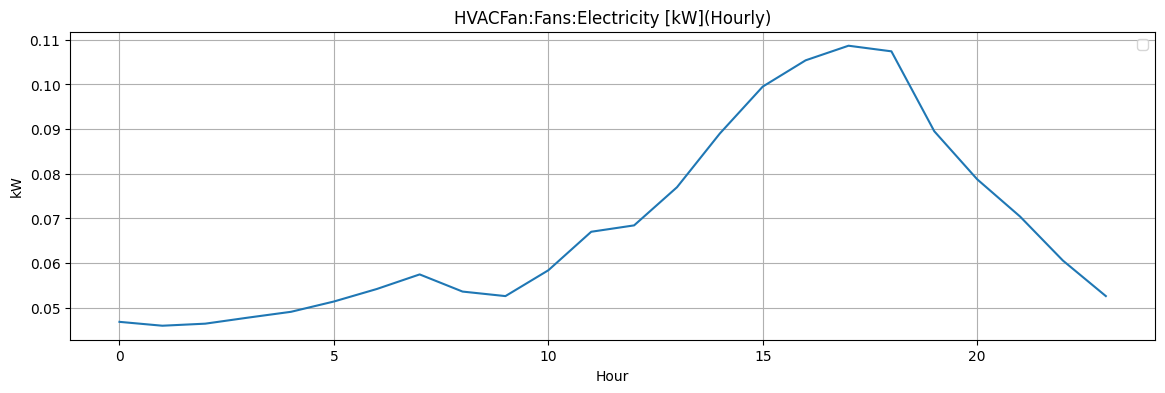

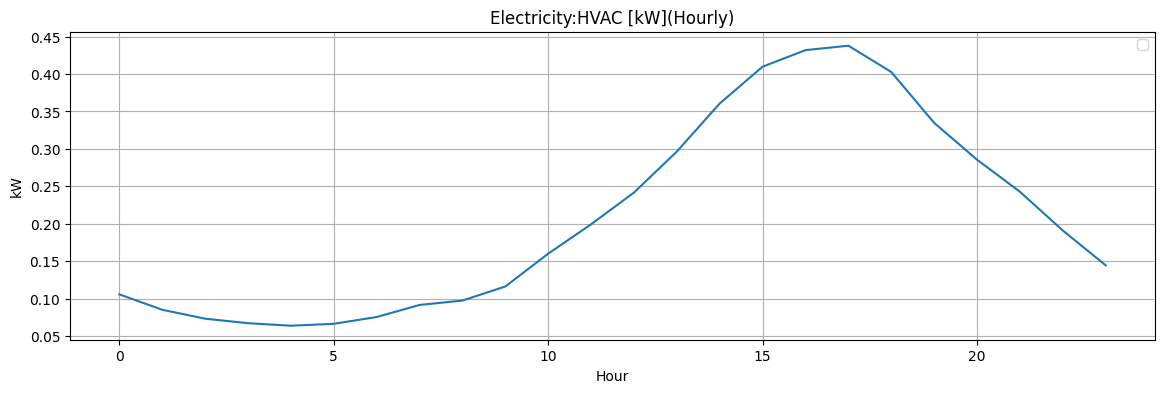

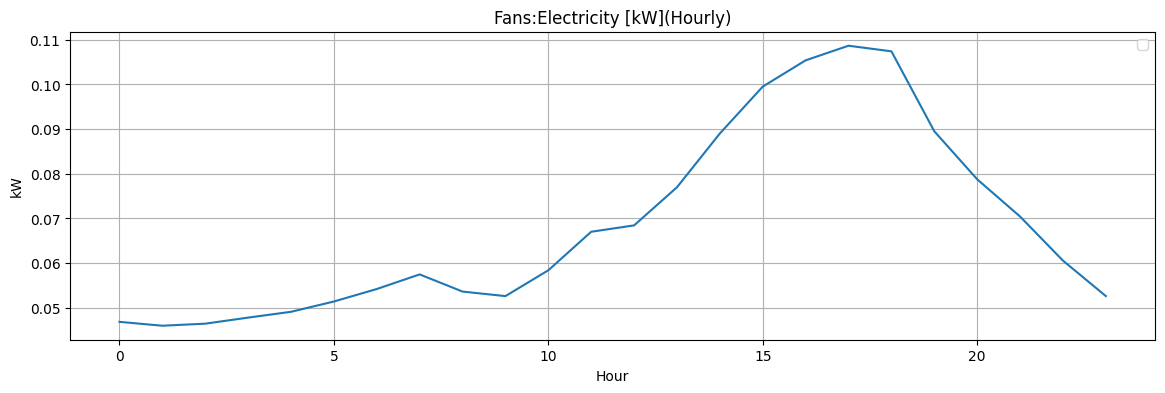

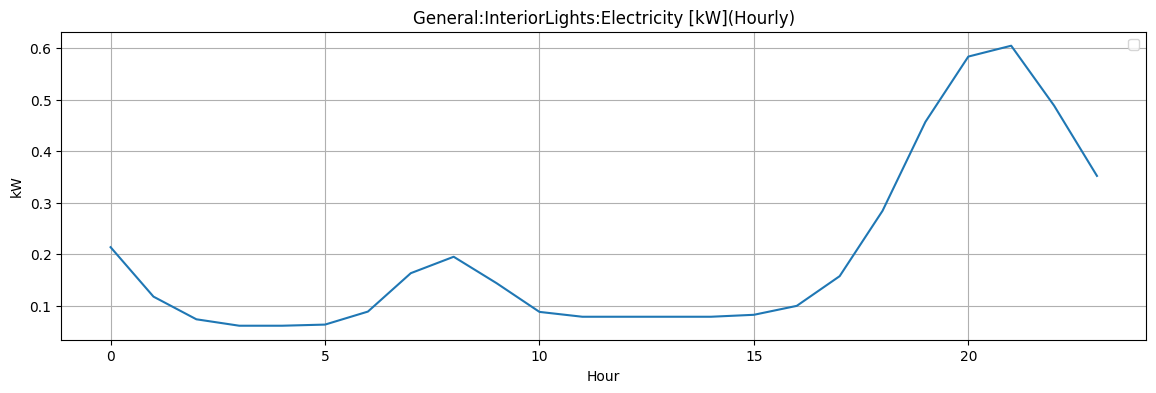

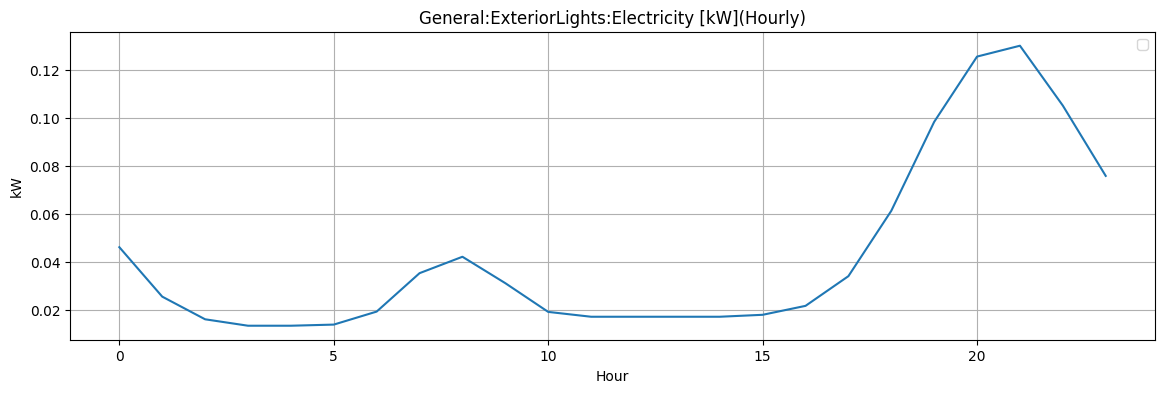

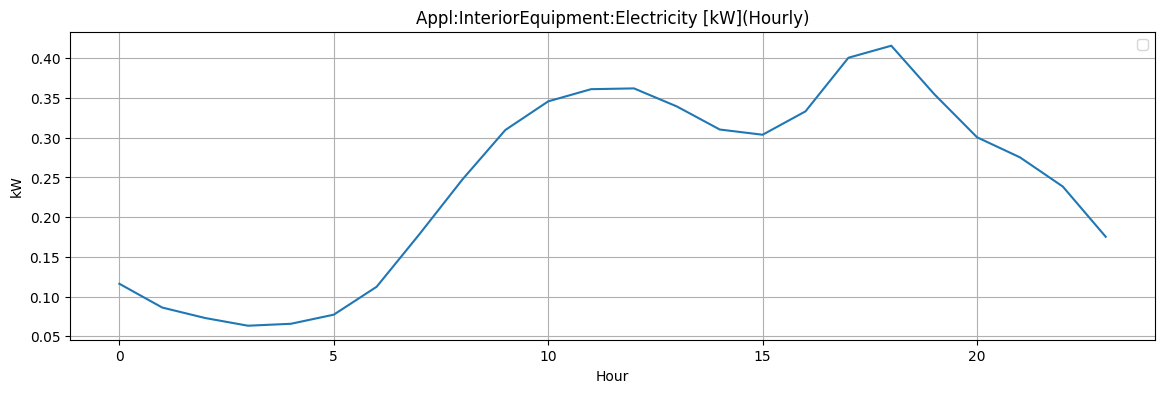

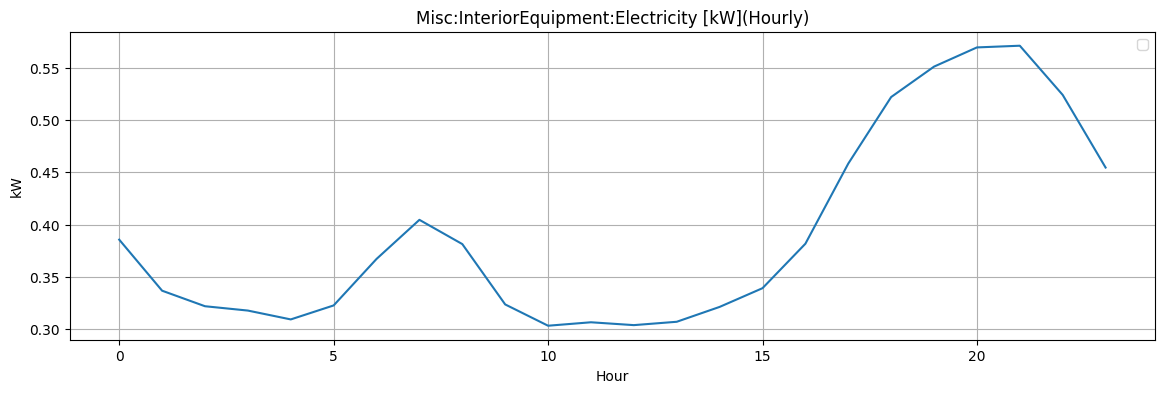

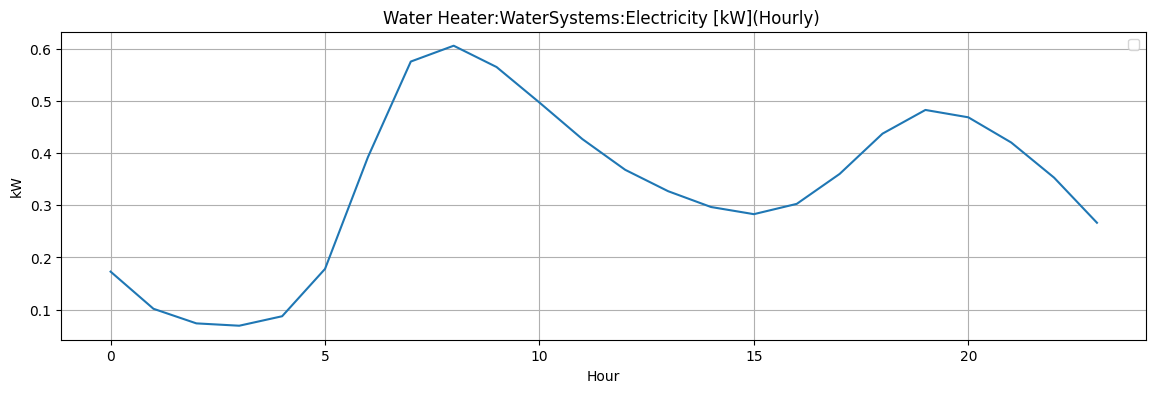

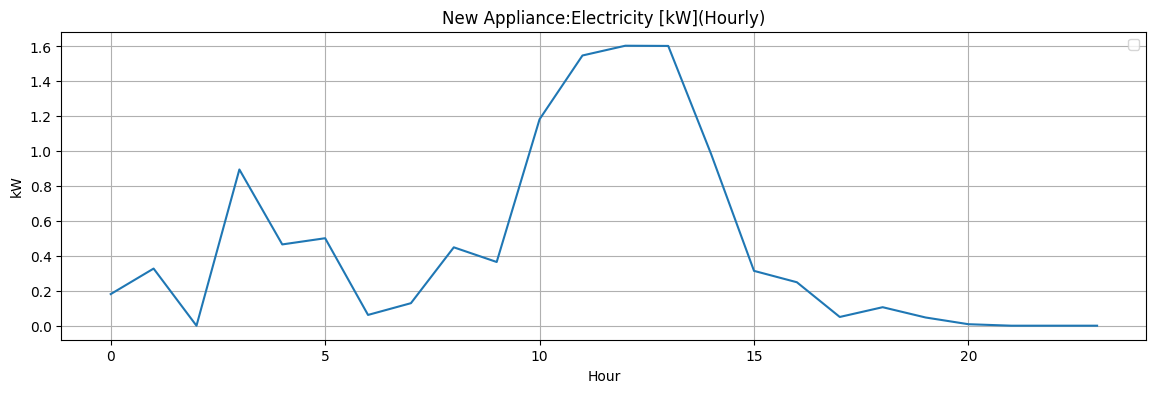

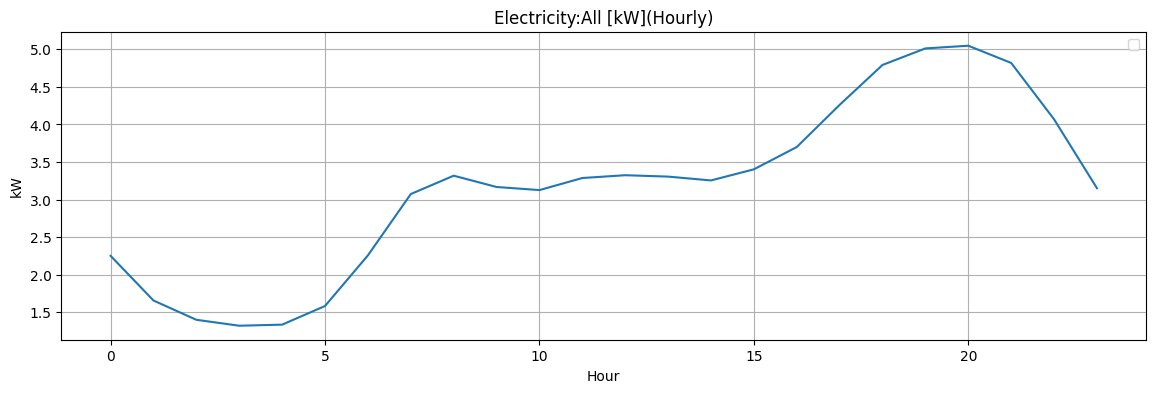

In [12]:
# Group data by hour

data_hour = data_electricity.copy()
data_hour['hour'] = [x.hour for x in data_hour.index]
data_hour = data_hour.groupby('hour').mean()

data = data_hour
for i in range(len(data.columns)): 
  plt.figure(i, figsize = (14, 4))
  plt.plot(data.index, data[data.columns[i]])
  plt.xlabel('Hour')
  plt.ylabel('kW')
  plt.title(data.columns[i])
  plt.legend()
  plt.grid()